In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils/')
from data_utils import get_image_folders
from train_utils import train

# utils specific to quantization
sys.path.append('../densenet_ternary_quantization/')
from utils import train, quantize, initial_scales

torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 512

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

# Model

In [6]:
from get_squeezenet import get_model

In [7]:
model, criterion, optimizer = get_model()

# load pretrained model, accuracy ~52%
model.load_state_dict(torch.load('../vanilla_squeezenet/model.pytorch_state'))

#### Keep copy of full precision kernels

In [8]:
# copy almost all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[1]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

#### initial quantization 

In [9]:
# scaling factors for each quantized layer
initial_scaling_factors = []

In [10]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[1]['params']]

In [11]:
for k, k_fp in zip(all_kernels, all_fp_kernels):
    
    # choose initial scaling factors 
    w_p_initial, w_n_initial = initial_scales(k_fp.data)
    initial_scaling_factors += [(w_p_initial, w_n_initial)]
    
    # do quantization, this uses hyperparameter 't'
    k.data = quantize(k_fp.data, w_p_initial, w_n_initial, t=0.1)

#### parameter updaters

In [12]:
# optimizer for updating only all_fp_kernels
optimizer_fp = optim.Adam(all_fp_kernels, lr=1e-4)

In [13]:
# optimizer for updating only scaling factors
optimizer_sf = optim.SGD([
    Variable(torch.FloatTensor([w_p, w_n]).cuda(), requires_grad=True) 
    for w_p, w_n in initial_scaling_factors
], lr=1e-4)

# Train

In [14]:
n_epochs = 5
n_batches = ceil(train_size/batch_size)

# total number of batches in the train set
n_batches

196

In [15]:
%%time
all_losses = train(
    model, criterion, [optimizer, optimizer_fp, optimizer_sf],
    0.1, # ternary quantization's hyperparameter 't'
    train_iterator, n_epochs, steps_per_epoch=n_batches,
    val_iterator=val_iterator, n_validation_batches=40,
    patience=9, threshold=0.01, # early stopping
    lr_scheduler=None
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  18.617 15.220  0.293 0.294  0.558 0.555  122.449
1  10.384 8.601  0.302 0.304  0.568 0.567  118.406
2  6.587 5.233  0.281 0.289  0.543 0.542  118.394
3  4.391 3.614  0.265 0.288  0.522 0.542  118.505
4  3.494 3.211  0.281 0.305  0.542 0.571  118.557
CPU times: user 10min 21s, sys: 1min 41s, total: 12min 2s
Wall time: 9min 56s


# Loss/epoch plots

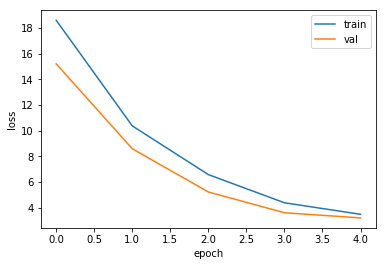

In [16]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

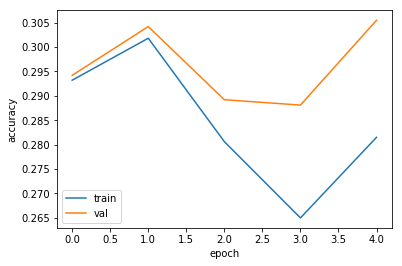

In [17]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

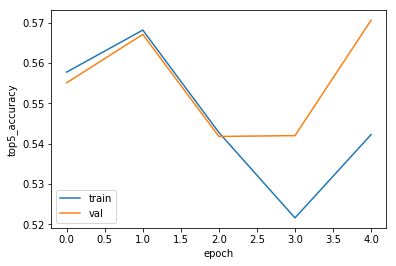

In [18]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [19]:
model.cpu();
torch.save(model.state_dict(), 'model_ternary_quantization.pytorch_state')